In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

# Load the data

In [2]:
import datetime
from helpers import *

height, weight, gender = load_data(sub_sample=False, add_outlier=False)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

In [3]:
y.shape, tx.shape

((10000,), (10000, 2))

### NB: throughout this laboratory the data has the following format: 
  * there are **N = 10000** data entries
  * **y** represents the column vector containing weight information -- that which we wish to predict/the output (see also the first page of $\texttt{exercise02.pdf}$). Its **shape** is **(N,)**.
  * **tx** represents the matrix $\tilde{X}$ formed by laterally concatenating a column vector of 1s to the column vector of height information -- the input data (see also the first page of $\texttt{exercise02.pdf}$). Its **shape** is **(N,2)**.

# 1. Computing the Cost Function
Fill in the `compute_loss` function below:

In [4]:
def compute_loss(y, tx, w, MSE = True):
    """Calculate the loss using either MSE or MAE.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2,). The vector of model parameters.

    Returns:
        the value of the loss (a scalar), corresponding to the input parameters w.
    """
    e = y - tx @ w
    if MSE:
        loss = 1/(2*len(y)) *np.linalg.norm(e)**2
    else:
        loss = 1/(2*len(y)) * sum(abs(e))
    return loss

In [5]:
w = [2,1]
loss = compute_loss(y, tx, w, MSE=False)
loss

35.6469610010525

# 2. Grid Search

Fill in the function `grid_search()` below:

In [6]:
# from costs import *


def grid_search(y, tx, grid_w0, grid_w1):
    """Algorithm for grid search.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        grid_w0: numpy array of shape=(num_grid_pts_w0, ). A 1D array containing num_grid_pts_w0 values of parameter w0 to be tested in the grid search.
        grid_w1: numpy array of shape=(num_grid_pts_w1, ). A 1D array containing num_grid_pts_w1 values of parameter w1 to be tested in the grid search.

    Returns:
        losses: numpy array of shape=(num_grid_pts_w0, num_grid_pts_w1). A 2D array containing the loss value for each combination of w0 and w1
    """

    losses = np.zeros((len(grid_w0), len(grid_w1)))
    for i in range(len(grid_w0)):
        for j in range(len(grid_w1)):
            w = [grid_w0[i], grid_w1[j]]
            losses[i][j] = compute_loss(y, tx,w,)
    return losses

Let us play with the grid search demo now!

Grid Search: loss*=15.765788547059048, w0*=72.88135593220338, w1*=12.711864406779654, execution time=0.381 seconds


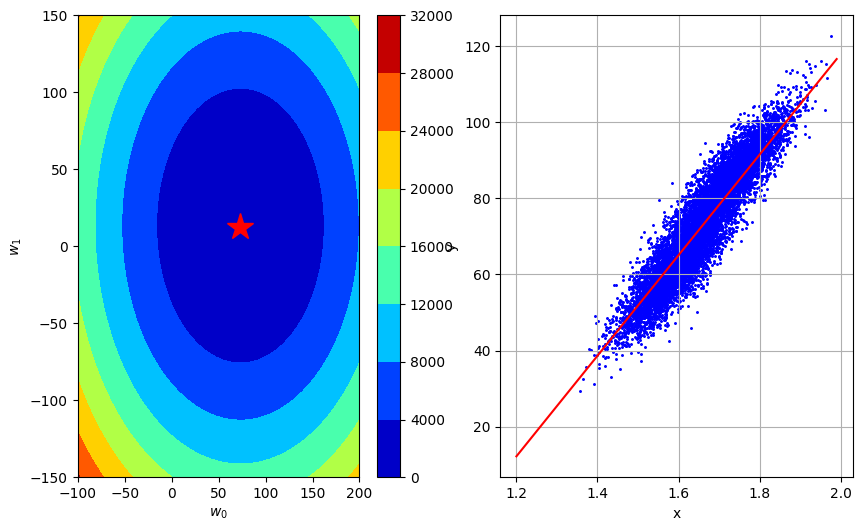

In [7]:
from grid_search import generate_w, get_best_parameters
from plots import grid_visualization

# Generate the grid of parameters to be swept
grid_w0, grid_w1 = generate_w(num_intervals=60)

# Start the grid search
start_time = datetime.datetime.now()
grid_losses = grid_search(y, tx, grid_w0, grid_w1)

# Select the best combinaison
loss_star, w0_star, w1_star = get_best_parameters(grid_w0, grid_w1, grid_losses)
end_time = datetime.datetime.now()
execution_time = (end_time - start_time).total_seconds()

# Print the results
print(
    "Grid Search: loss*={l}, w0*={w0}, w1*={w1}, execution time={t:.3f} seconds".format(
        l=loss_star, w0=w0_star, w1=w1_star, t=execution_time
    )
)

# Plot the results
fig = grid_visualization(grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight)
fig.set_size_inches(10.0, 6.0)
fig.savefig("grid_plot")  # Optional saving

# 3. Gradient Descent

Again, please fill in the functions `compute_gradient` below:

In [8]:
def compute_gradient(y, tx, w):
    """Computes the gradient at w.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        An numpy array of shape (2, ) (same shape as w), containing the gradient of the loss at w.
    """
    return -1/len(y) * (tx.T @ (y - tx @ w))

In [9]:
w0 = [100,20]
w1 = [50,10]
result_w0 = compute_gradient(y,tx,w0)
result_w1 = compute_gradient(y,tx,w1)
np.set_printoptions(precision=3)
print(f'The gradient using w0 is: {result_w0} and using w1 is: {result_w1}')

The gradient using w0 is: [26.706  6.52 ] and using w1 is: [-23.294  -3.48 ]


Please fill in the functions `gradient_descent` below:

In [10]:
def gradient_descent(y, tx, initial_w, max_iters, gamma):
    """The Gradient Descent (GD) algorithm.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        max_iters: a scalar denoting the total number of iterations of GD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of GD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of GD
    """
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        loss = compute_loss(y,tx,w)
        w = w - gamma * compute_gradient(y,tx,w)
        # store w and loss
        ws.append(w)
        losses.append(loss)
        print(
            "GD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )

    return losses, ws

Test your gradient descent function through gradient descent demo shown below:

In [11]:
# from gradient_descent import *
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.9

# Initialization
w_initial = np.array([-1000,1000])

# Start gradient descent.
start_time = datetime.datetime.now()
gd_losses, gd_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("GD: execution time={t:.3f} seconds".format(t=exection_time))

GD iter. 0/49: loss=1062606.4462798766, w0=-34.03547019810537, w1=112.13174119148891
GD iter. 1/49: loss=10641.29649178879, w0=62.56098278208415, w1=23.344915310638783
GD iter. 2/49: loss=121.64499390802628, w0=72.2206280801031, w1=14.466232722553986
GD iter. 3/49: loss=16.448478929221324, w0=73.18659260990498, w1=13.578364463745542
GD iter. 4/49: loss=15.39651377943332, w0=73.28318906288517, w1=13.489577637864699
GD iter. 5/49: loss=15.385994127935446, w0=73.29284870818319, w1=13.480698955276614
GD iter. 6/49: loss=15.385888931420459, w0=73.29381467271298, w1=13.479811087017804
GD iter. 7/49: loss=15.38588787945531, w0=73.29391126916597, w1=13.479722300191924
GD iter. 8/49: loss=15.385887868935662, w0=73.29392092881127, w1=13.479713421509336
GD iter. 9/49: loss=15.385887868830464, w0=73.29392189477579, w1=13.479712533641077
GD iter. 10/49: loss=15.385887868829416, w0=73.29392199137226, w1=13.479712444854252
GD iter. 11/49: loss=15.385887868829403, w0=73.29392200103189, w1=13.479712435

In [12]:
# Time Visualization
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gd_losses,
        gd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(gd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

# 4. Stochastic gradient descent

In [13]:
def compute_stoch_gradient(y, tx, w):
    """Compute a stochastic gradient at w from a data sample batch of size B, where B < N, and their corresponding labels.

    Args:
        y: numpy array of shape=(B, )
        tx: numpy array of shape=(B,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        A numpy array of shape (2, ) (same shape as w), containing the stochastic gradient of the loss at w.
    """

    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO: implement stochastic gradient computation. It's the same as the usual gradient.
    return -1/len(y) * (tx.T @ (y - tx @ w))
    # ***************************************************


def stochastic_gradient_descent(y, tx, initial_w, batch_size, max_iters, gamma):
    """The Stochastic Gradient Descent algorithm (SGD).

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        batch_size: a scalar denoting the number of data points in a mini-batch used for computing the stochastic gradient
        max_iters: a scalar denoting the total number of iterations of SGD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SGD
    """

    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w

    for n_iter in range(max_iters):
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: implement stochastic gradient descent.
        for y_batched, tx_batched in batch_iter(y=y,tx=tx,batch_size=batch_size):
            loss = compute_loss(y_batched,tx_batched,w)
            w = w - gamma * compute_stoch_gradient(y_batched,tx_batched,w)
        # ***************************************************
        # store w and loss
        ws.append(w)
        losses.append(loss)
        print(
            "SGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )
    return losses, ws

In [14]:
# from stochastic_gradient_descent import *

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.1
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SGD.
start_time = datetime.datetime.now()
sgd_losses, sgd_ws = stochastic_gradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma
)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD iter. 0/49: loss=4474.061199117087, w0=9.459451568793074, w1=18.39043569151485
SGD iter. 1/49: loss=3048.19308045315, w0=17.267387378535815, w1=13.953924651189439
SGD iter. 2/49: loss=1658.9196280477036, w0=23.027456176818877, w1=9.23843714778819
SGD iter. 3/49: loss=1047.9698562938822, w0=27.605599591553464, w1=5.489050124728406
SGD iter. 4/49: loss=992.0956857180238, w0=32.06002589741603, w1=6.033186267656118
SGD iter. 5/49: loss=232.33138775234477, w0=34.215629700309066, w1=1.726335682422861
SGD iter. 6/49: loss=1006.9630895479743, w0=38.703308587101155, w1=3.001387541639837
SGD iter. 7/49: loss=881.6461638113914, w0=42.90246603547432, w1=7.3946502124567
SGD iter. 8/49: loss=89.986211796291, w0=44.244004046835094, w1=6.1216679495218935
SGD iter. 9/49: loss=957.6501661956216, w0=48.62041848378144, w1=12.364248368942963
SGD iter. 10/49: loss=125.21943820694389, w0=50.202944554384665, w1=12.59211892643459
SGD iter. 11/49: loss=68.28941363919074, w0=51.37161399985837, w1=10.11467394

In [15]:
# Time Visualization
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        sgd_losses,
        sgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(sgd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

# 5. Effect of Outliers and MAE Cost Function

In [16]:
import datetime
from helpers import *

# ***************************************************
# INSERT YOUR CODE HERE
# TODO: reload the data by subsampling first, then by subsampling and adding outliers
height, weight, gender = load_data(sub_sample=True, add_outlier=True)

# ***************************************************

x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

In [17]:
y.shape, tx.shape

((202,), (202, 2))

In [18]:
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()

# ***************************************************
# INSERT YOUR CODE HERE
# TODO: fit the model to the subsampled data / subsampled data with outliers and visualize the cloud of points
#       and the model fit
gd_losses, gd_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)
# ***************************************************


end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("GD: execution time={t:.3f} seconds".format(t=exection_time))

GD iter. 0/49: loss=2869.8351145358533, w0=51.847464098448484, w1=7.724426406192441
GD iter. 1/49: loss=318.282124701595, w0=67.401703327983, w1=10.041754328050121
GD iter. 2/49: loss=88.64235561651259, w0=72.06797509684336, w1=10.736952704607413
GD iter. 3/49: loss=67.9747763988552, w0=73.46785662750146, w1=10.945512217574594
GD iter. 4/49: loss=66.11469426926604, w0=73.88782108669889, w1=11.00808007146475
GD iter. 5/49: loss=65.947286877603, w0=74.01381042445813, w1=11.026850427631796
GD iter. 6/49: loss=65.93222021235334, w0=74.05160722578589, w1=11.03248153448191
GD iter. 7/49: loss=65.93086421248087, w0=74.06294626618423, w1=11.034170866536943
GD iter. 8/49: loss=65.93074217249236, w0=74.06634797830372, w1=11.034677666153454
GD iter. 9/49: loss=65.93073118889338, w0=74.06736849193958, w1=11.034829706038407
GD iter. 10/49: loss=65.93073020036948, w0=74.06767464603033, w1=11.034875318003893
GD iter. 11/49: loss=65.93073011140233, w0=74.06776649225756, w1=11.034889001593537
GD iter. 

In [19]:
# Time Visualization
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gd_losses,
        gd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(gd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

# 6. Subgradient descent

In [20]:
def compute_subgradient_mae(y, tx, w):
    """Compute a subgradient of the MAE at w.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        A numpy array of shape (2, ) (same shape as w), containing the subgradient of the MAE at w.
    """
    e = y - (tx @ w)
    subgradient = (-tx.T @ np.sign(e))/len(y)
    return subgradient


In [21]:
def subgradient_descent(y, tx, initial_w, max_iters, gamma):
    """The SubGradient Descent (SubGD) algorithm.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        max_iters: a scalar denoting the total number of iterations of GD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SubGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SubGD
    """
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        w = w - gamma * compute_subgradient_mae(y,tx,w)
        loss = compute_loss(y,tx,w,MSE=False)
        ws.append(w)
        losses.append(loss)
        print(
            "SubGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )

    return losses, ws

In [22]:
# Define the parameters of the algorithm.
max_iters = 500
gamma = 0.7
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SubSGD.
start_time = datetime.datetime.now()
subgd_losses, subgd_ws = subgradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SubGD: execution time={t:.3f} seconds".format(t=exection_time))

SubGD iter. 0/499: loss=36.6839029274632, w0=0.7, w1=8.756471895211877e-16
SubGD iter. 1/499: loss=36.33390292746317, w0=1.4, w1=1.7512943790423754e-15
SubGD iter. 2/499: loss=35.983902927463205, w0=2.0999999999999996, w1=2.626941568563563e-15
SubGD iter. 3/499: loss=35.63390292746321, w0=2.8, w1=3.502588758084751e-15
SubGD iter. 4/499: loss=35.28390292746316, w0=3.5, w1=4.378235947605939e-15
SubGD iter. 5/499: loss=34.933902927463194, w0=4.2, w1=5.253883137127127e-15
SubGD iter. 6/499: loss=34.58390292746317, w0=4.9, w1=6.1295303266483146e-15
SubGD iter. 7/499: loss=34.233902927463205, w0=5.6000000000000005, w1=7.0051775161695025e-15
SubGD iter. 8/499: loss=33.88390292746321, w0=6.300000000000001, w1=7.88082470569069e-15
SubGD iter. 9/499: loss=33.53390292746315, w0=7.000000000000001, w1=8.756471895211878e-15
SubGD iter. 10/499: loss=33.183902927463194, w0=7.700000000000001, w1=9.632119084733065e-15
SubGD iter. 11/499: loss=32.83390292746318, w0=8.4, w1=1.0507766274254253e-14
SubGD it

In [23]:
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        subgd_losses,
        subgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(subgd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=501, min=1), Output()), _dom_classes=('widg…

<function __main__.plot_figure(n_iter)>

# Stochastic Subgradient Descent

**NB** for the computation of the subgradient you can reuse the `compute_subgradient` method that you implemented above, just making sure that you pass in a minibatch as opposed to the full data.

In [24]:
def stochastic_subgradient_descent(y, tx, initial_w, batch_size, max_iters, gamma):
    """Compute a stochastic subgradient at w from a data sample batch of size B, where B < N, and their corresponding labels.

    Args:
        y: numpy array of shape=(B, )
        tx: numpy array of shape=(B,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        batch_size: a scalar denoting the number of data points in a mini-batch used for computing the stochastic subgradient
        max_iters: a scalar denoting the total number of iterations of SubSGD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SubSGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SubSGD
    """

    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w

    for n_iter in range(max_iters):
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: implement stochastic subgradient descent.
        for y_batched, tx_batched in batch_iter(y=y,tx=tx,batch_size=batch_size):
            loss = compute_loss(y_batched,tx_batched,w, MSE=False)
            w = w - gamma * compute_subgradient_mae(y_batched,tx_batched,w)
        ws.append(w)
        losses.append(loss)
        # ***************************************************

        print(
            "SubSGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )
    return losses, ws

In [25]:
# Define the parameters of the algorithm.
max_iters = 500
gamma = 0.7
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SubSGD.
start_time = datetime.datetime.now()
subsgd_losses, subsgd_ws = stochastic_subgradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma
)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SubSGD: execution time={t:.3f} seconds".format(t=exection_time))

SubSGD iter. 0/499: loss=29.742046300567097, w0=0.7, w1=-0.6965847512407627
SubSGD iter. 1/499: loss=44.60724097773134, w0=1.4, w1=0.06477219937830658
SubSGD iter. 2/499: loss=39.70958453833837, w0=2.0999999999999996, w1=0.40848482056169716
SubSGD iter. 3/499: loss=28.682608057322557, w0=2.8, w1=-0.01475460421081709
SubSGD iter. 4/499: loss=47.11211486541779, w0=3.5, w1=1.1912616855596299
SubSGD iter. 5/499: loss=38.563029970215716, w0=4.2, w1=1.848444388754615
SubSGD iter. 6/499: loss=36.99519958674307, w0=4.9, w1=1.9917749793491313
SubSGD iter. 7/499: loss=28.60392430945605, w0=5.6000000000000005, w1=1.552086574263947
SubSGD iter. 8/499: loss=41.73322844429849, w0=6.300000000000001, w1=2.1667475553943336
SubSGD iter. 9/499: loss=25.25421780241269, w0=7.000000000000001, w1=1.1899500764524147
SubSGD iter. 10/499: loss=31.414799312928437, w0=7.700000000000001, w1=1.4506622978342785
SubSGD iter. 11/499: loss=21.083403492791618, w0=8.4, w1=0.7700631201781958
SubSGD iter. 12/499: loss=50.0

In [26]:
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        subsgd_losses,
        subsgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(subsgd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=501, min=1), Output()), _dom_classes=('widg…

<function __main__.plot_figure(n_iter)>